In [1]:
import os
import pandas as pd

allcards = pd.read_json('AllCards.json')

['AveragePower', 'AverageCMCCreatures', 'ToughnessToCMC', 'AverageCMC', 'MaxCMC', 'PowerToCMC', 'PowerToToughness', 'CreatureDensity', 'AverageToughness']


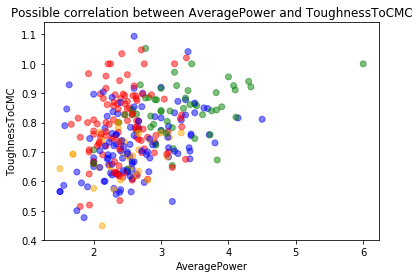

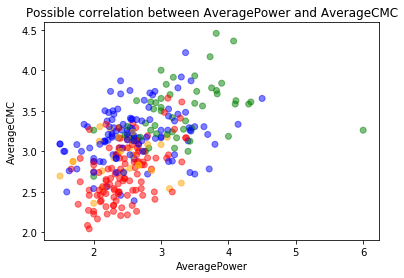

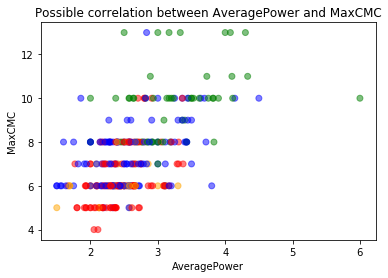

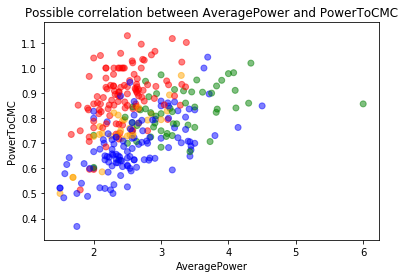

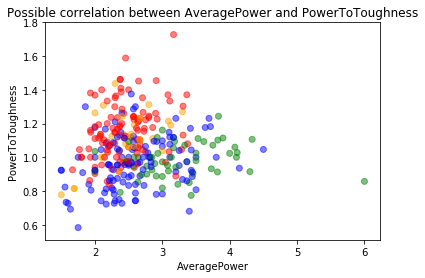

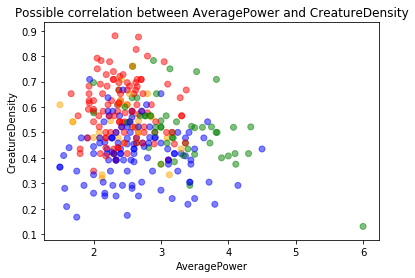

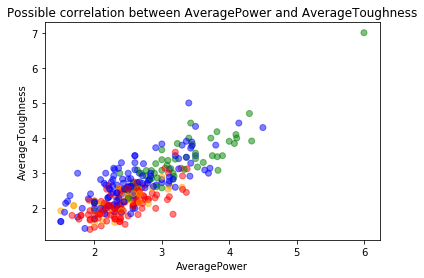

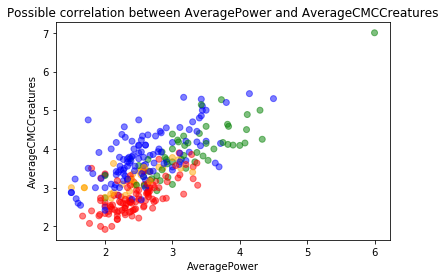

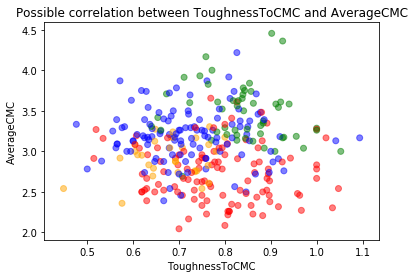

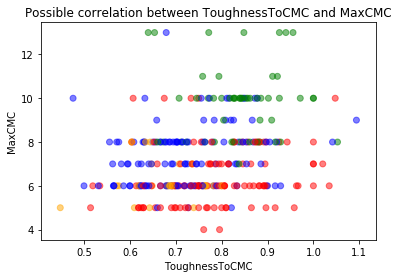

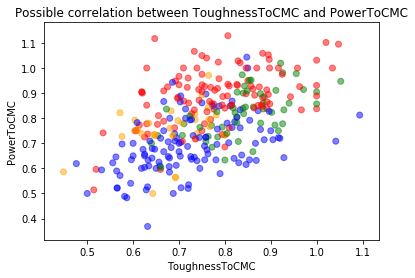

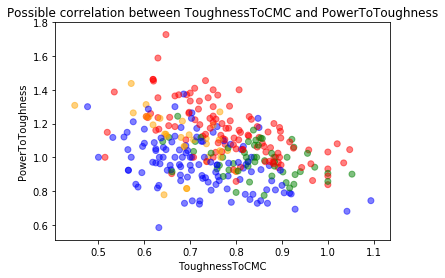

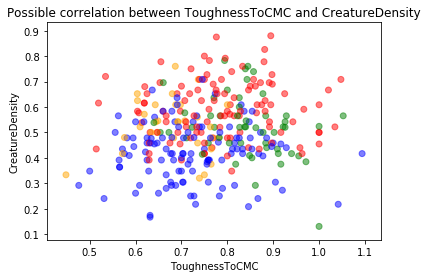

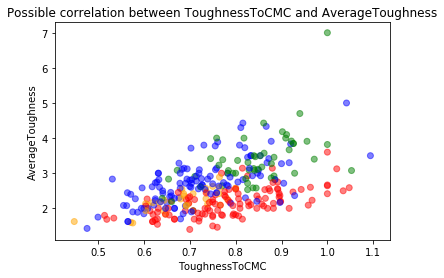

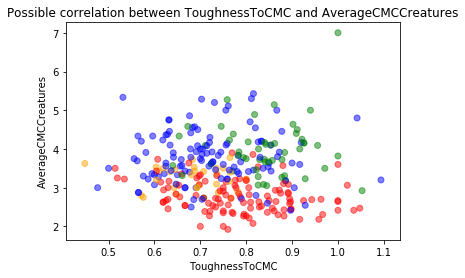

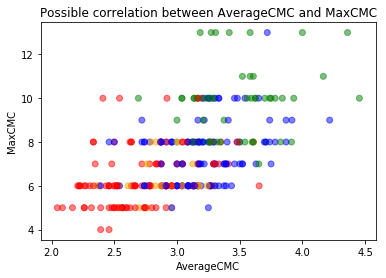

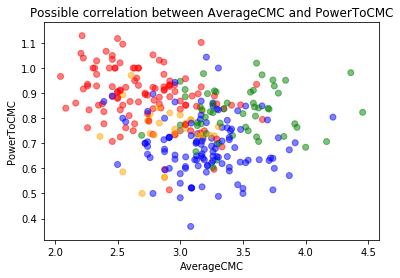

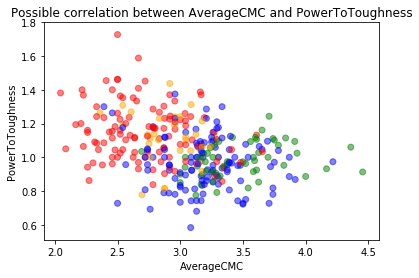

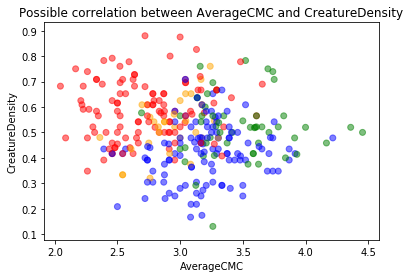

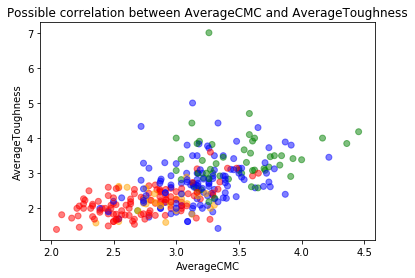

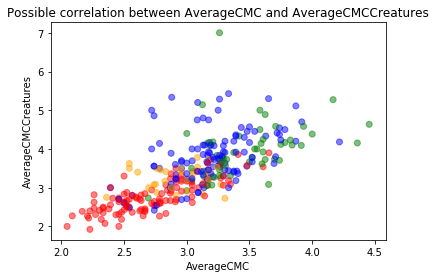

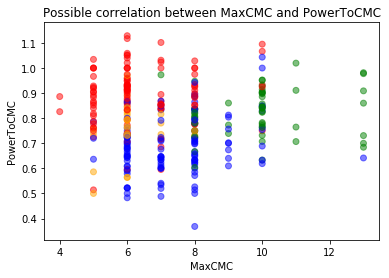

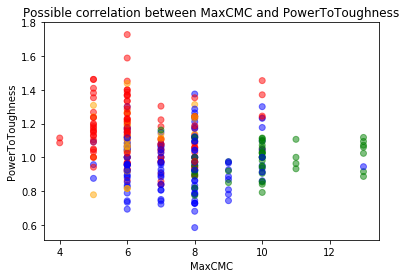

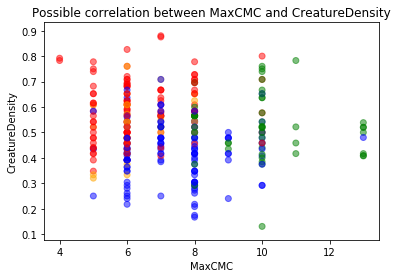

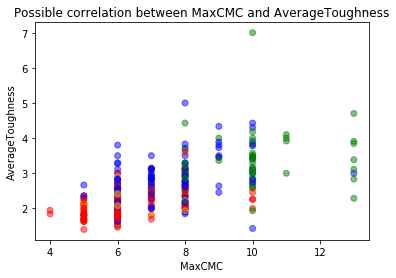

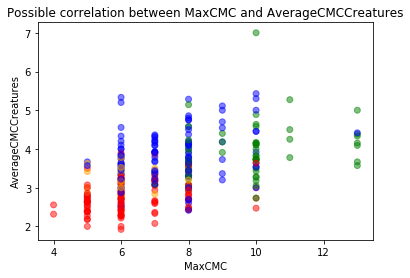

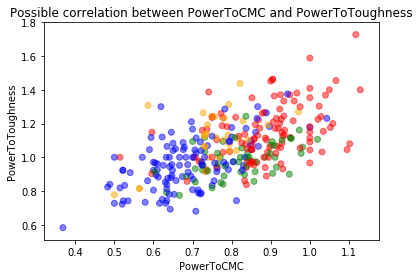

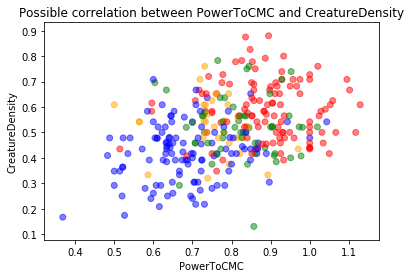

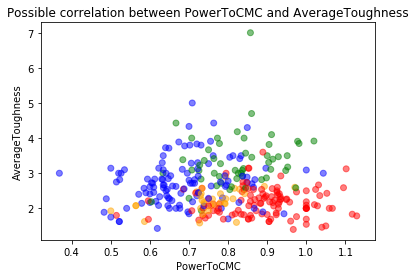

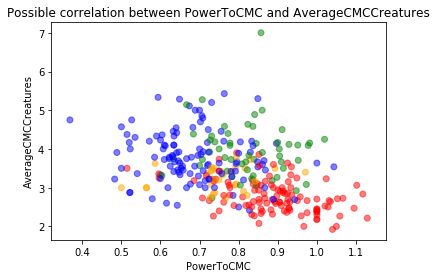

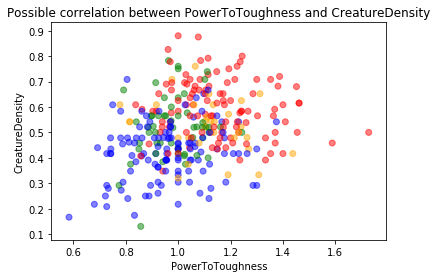

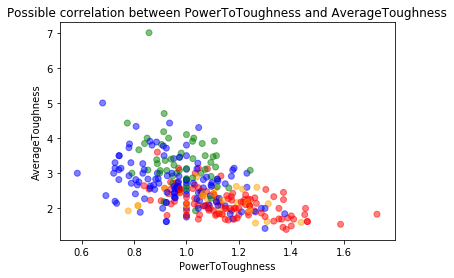

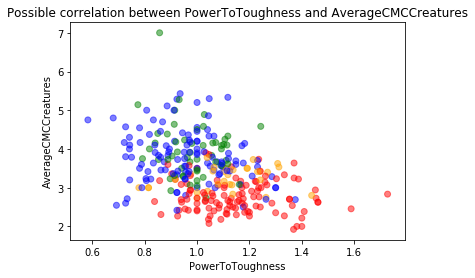

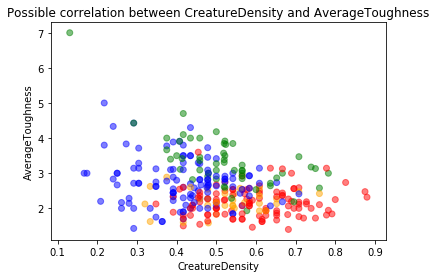

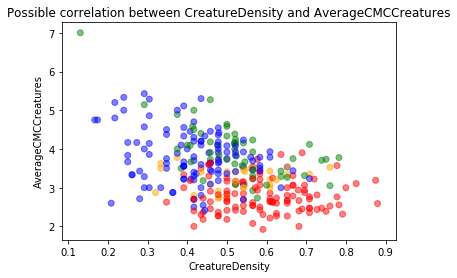

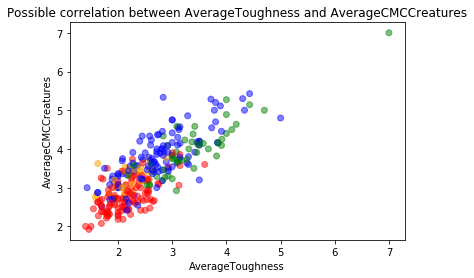

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

decklists_path = 'data/decks/'

class ArchetypeWorkshop():
        def __init__(self):
            self.deckfiles = []
            self.loadAllDeckFilenames()
            self.decks = []
            self.loadAllDecks()
            self.cards = []
            self.loadAllUsedCards()
            self.used_cards = []
            self.loadAllUsedCardsData()
            self.allcards =  allcards#[]
            #self.loadAllCardsData()
            self.deck_and_name=[]
            self.df = []
            self.decknames = []
            
            self.all_params = [ 
                'AverageCMC',
                'AverageCMCCreatures',
                'CreatureDensity',
                'PowerToToughness',
                'PowerToCMC',
                'ToughnessToCMC',
                'MaxCMC',
                'AveragePower',
                'AverageToughness' ]
            
        def loadAllDeckFilenames(self):
            if len(self.deckfiles) == 0:
                tmp = os.listdir(decklists_path)
                deckfiles = []
                for i in tmp:
                    deckfiles.append(i.replace('~', ''))
                self.deckfiles = list(set(deckfiles))
                
        def loadDecks(self, filename):
            data = pd.read_json('data/decks/'+filename)
            return data['cards']
    
        def loadAllDecks(self):
            self.loadAllDeckFilenames()
            for i in self.deckfiles:
                tmp_decks = self.loadDecks(i)
                for d in tmp_decks:
                    self.decks.append(d)
    
        def loadAllUsedCards(self):
            if len(self.cards) == 0:
                self.loadAllDecks()
                for i in self.decks:
                    for j in i:
                        if "(ORI)" not in j:
                            self.cards.append(j)
                self.cards = sorted(list(set(self.cards)))
                
        def loadAllCardsData(self):
            if os.path.isfile('AllCards.json') == False:
                self.downloadAllCardsData()
            if len(self.allcards) == 0:
                self.allcards = pd.read_json('AllCards.json')
                
        def loadAllUsedCardsData(self):
            self.used_cards = pd.read_json('used_cards.json')
                
        def prepareAllUsedCardsData(self):
            used_cards = []
            for i in self.cards:
                used_cards.append(self.allcards[i])
            self.used_cards = used_cards
            
        def saveUsedCardsAsJson(self):
            df = pd.DataFrame(self.used_cards)
            df.to_json('used_cards.json')
            
            
        # actual archetype detection methods start here
        
        def loadDecksWithNames(self, filename):
            data = pd.read_json('data/decks/'+filename)
            return data['cards'], data['name']
        
        def loadAllDecksWithNames(self):
            self.loadAllDeckFilenames()
            for i in self.deckfiles:
                tmp_decks, tmp_names = self.loadDecksWithNames(i)
                for i in range(0, len(tmp_decks)):
                    self.deck_and_name.append((tmp_decks[i], tmp_names[i]))
                    
        def loadDeckWithAllInfo(self, filename):
            data = pd.read_json('data/decks/'+filename)
            return data['cards'], data['name'], data['player'], data['draft']
        
        def loadAllDecksWithAll(self):
            self.loadAllDeckFilenames()
            for i in self.deckfiles:
                tmp_decks, tmp_names, tmp_players, tmp_drafts = self.loadDeckWithAllInfo(i)
                for i in range(0, len(tmp_decks)):
                    self.deck_and_name.append([tmp_decks[i], tmp_names[i], tmp_players[i], tmp_drafts[i]])
            self.prepareDecknames()
                    
        def showCardTypes(self, deck):
            for i in deck:
                print self.allcards[i]['types']
                
        def getNonlandsOnly(self, deck):
            nonlands = []
            for i in deck:
                if 'Land' not in self.allcards[i]['types']:
                    nonlands.append(i)
            return nonlands
        
        def getNumberOfCardType(self, deck, cardtype):
            acc = 0
            for i in deck:
                if cardtype in self.allcards[i]['types']:
                    acc+=1
            return acc
        
        def getAverageCMC(self, deck):
            acc = 0
            for i in deck:
                acc+=self.allcards[i]['convertedManaCost']
                
            return round((acc+0.0)/len(deck), 4)
        
        def getAverageCMCForType(self, deck, cardtype):
            acc = 0
            counter = 0
            for i in deck:
                if cardtype in self.allcards[i]['types']:
                    acc+=self.allcards[i]['convertedManaCost']
                    counter+=1
            return round((acc+0.0)/counter, 4)
        
        def getMinMaxMedian(self, deck):
            cmcs = []
            for i in deck:
                cmcs.append(self.allcards[i]['convertedManaCost'])
                
            npcmcs = np.array(cmcs)
            return {
                'min': np.min(npcmcs),
                'max': np.max(npcmcs),
                'median': np.median(npcmcs)
            }
        
        def getAveragePowerToughness(self, deck):
            total_power = 0
            total_tough = 0
            total_cmc=0
            number = self.getNumberOfCardType(deck, 'Creature')
            for i in deck:
                if 'Creature' in self.allcards[i]['types']:
                    if self.allcards[i]['power'] not in ['X', '*', '1+*']:
                        total_power += int(self.allcards[i]['power'])
                    if self.allcards[i]['toughness'] not in ['X', '*', '1+*']:
                        total_tough += int(self.allcards[i]['toughness'])
                    total_cmc+=int(self.allcards[i]['convertedManaCost'])
            return {
                'ave_power': round((total_power+0.0)/number, 4),
                'ave_tough': round((total_tough+0.0)/number, 4),
                'total_power': total_power,
                'total_tough': total_tough,
                'power_cmc': round(total_power/(0.0+total_cmc), 4),
                'tough_cmc': round(total_tough/(0.0+total_cmc), 4)
            }
            
        def examineDeck(self, i, chosen_params):
            deck = self.deck_and_name[i][0]
            nonlands = self.getNonlandsOnly(deck)
            deck_name = self.deck_and_name[i][1]
            player_name = self.deck_and_name[i][2]
            draft_num = self.deck_and_name[i][3]
            tmp = deck_name.split(' ')
            simple_name = tmp[1]
                    
            min_max_median = self.getMinMaxMedian(deck)
            average_power_toughness = self.getAveragePowerToughness(nonlands)
            creature_density = round(self.getNumberOfCardType(nonlands, 'Creature')/(0.0 + len(nonlands)), 4)
            power_to_toughness = round(average_power_toughness['total_power']/(0.0+average_power_toughness['total_tough']), 4)
                     
            param_dict = {'Name': simple_name, 'Player and draft':player_name+'_'+draft_num}
            
            if 'AverageCMC' in chosen_params: 
                param_dict['AverageCMC'] = self.getAverageCMC(nonlands)
            
            if 'AverageCMCCreatures' in chosen_params: 
                param_dict['AverageCMCCreatures'] = self.getAverageCMCForType(deck, 'Creature')
                
            if 'CreatureDensity' in chosen_params: 
                param_dict['CreatureDensity'] = creature_density
                
            if 'PowerToToughness' in chosen_params: 
                param_dict['PowerToToughness'] = power_to_toughness
                
            if 'PowerToCMC' in chosen_params: 
                param_dict['PowerToCMC'] = average_power_toughness['power_cmc']
                
            if 'ToughnessToCMC' in chosen_params: 
                param_dict['ToughnessToCMC'] = average_power_toughness['tough_cmc']
                
            if 'MaxCMC' in chosen_params: 
                param_dict['MaxCMC'] = min_max_median['max']
                
            if 'AveragePower' in chosen_params: 
                param_dict['AveragePower'] = average_power_toughness['ave_power']
                
            if 'AverageToughness' in chosen_params: 
                param_dict['AverageToughness'] = average_power_toughness['ave_tough']
        
            return param_dict
        
        def examineAllDecks(self, chosen_params):
            self.results_all_decks = []
            for i in range(len(self.deck_and_name)):
                self.results_all_decks.append(self.examineDeck(i, chosen_params))
                
        def convertResultsToDataFrame(self):
            my_keys = self.results_all_decks[0].keys()
            self.pre_df = {}
            for i in my_keys:
                self.pre_df[i] = []
            
            for i in self.results_all_decks:
                for j in my_keys:
                    self.pre_df[j].append(i[j])
            
            self.df = pd.DataFrame.from_dict(self.pre_df)
            
        def showDistributionForEachParameter(self):
            my_keys = self.results_all_decks[0].keys()
            self.pre_df = {}
            for i in my_keys:
                self.pre_df[i] = []
            
            for i in self.results_all_decks:
                for j in my_keys:
                    self.pre_df[j].append(i[j])
                        
            for i in my_keys:
                if i not in ['Name', 'Player and draft']:
                    print i,'Max: ', max(self.pre_df[i]), 'Min: ', min(self.pre_df[i])
                    hist = self.df[i].hist(bins = 20)
                    plt.style.use('ggplot')
                    plt.show()
                    
        def getAllNumericalKeyPairs(self):
            my_keys = self.results_all_decks[0].keys()
            numeric_keys = []
            for i in my_keys:
                if i not in ['Name', 'Player and draft']:
                    numeric_keys.append(i)
                    
            pairs = []
            for i in range (0, len(numeric_keys)):
                for j in range (i+1, len(numeric_keys)):
                    pairs.append((numeric_keys[i], numeric_keys[j]))
                
            return pairs
        
        def getColorsByArchetypes(self):
            archetype_color_dict = {
                'Aggro': 'red',
                'Control': 'blue',
                'Mid-Range': 'orange',
                'Ramp': 'green'
            }
            colors = []
            for i in self.pre_df['Name']:
                colors.append(archetype_color_dict[i])
            
            return colors   
                    
        def showScatterPlotsForParameterPairs(self):
            key_pairs = self.getAllNumericalKeyPairs()
            colors = self.getColorsByArchetypes()
            
            for i in range(0, len(key_pairs)):          
                x_key = key_pairs[i][0]
                y_key = key_pairs[i][1]
            
                x = self.pre_df[x_key]
                y = self.pre_df[y_key]
          
                plt.scatter(x, y, c=colors, alpha=0.5)
                plt.title('Possible correlation between '+x_key+' and '+y_key)
                plt.xlabel(x_key)
                plt.ylabel(y_key)
                 
                plt.show()
                
        def normalizeSingleValue(self, val, p_min, p_max):
             return round((val - p_min + 0.0) / (p_max - p_min), 4)
                
        def normalizeArray(self, my_array):
            tmp_arr = np.array(my_array)
            p_min = min(tmp_arr) 
            p_max = max(tmp_arr)
            
            normalized_array = []
            for i in my_array:
                normalized_value = self.normalizeSingleValue(i, p_min, p_max)
                normalized_array.append(normalized_value)
            
            return normalized_array
        
        def normalizeDataFrame(self):
            self.normalized_pre_df = {}
            my_keys = self.results_all_decks[0].keys()
            for k in my_keys:
                if k not in ['Name', 'Player and draft']:
                    norm_param = self.normalizeArray(self.pre_df[k])
                    self.normalized_pre_df[k] = norm_param
                else:
                    self.normalized_pre_df[k] = self.pre_df[k]
            
            self.normalized_df = pd.DataFrame.from_dict(self.normalized_pre_df)
            
        def convertNormalizedPreDfToCoordinates(self):
            my_keys = self.results_all_decks[0].keys()
            converted = {}
            for i in range(0, len(self.normalized_pre_df['Name'])):
                tmp_array = [] 
                tmp_key = self.normalized_pre_df['Player and draft'][i]+' '+self.normalized_pre_df['Name'][i]
                for j in my_keys:
                    if j not in ['Player and draft', 'Name']:
                        tmp_array.append(self.normalized_pre_df[j][i])

                converted[tmp_key]=tmp_array
            self.deck_coordinates = converted
            
        def calculateDistanceBetweenTwoDecks(self, co1, co2):
            sum = 0
            for i in range(0, len(co1)):
                sum+=(co1[i]-co2[i])**2
            distance = np.sqrt(sum)
            return distance
            
        def findClosestDeck(self, deck_name, show_option):
            my_keys = self.deck_coordinates.keys()
            my_deck_co = self.deck_coordinates[deck_name]
            min_dist = 100
            close_deck = 'None'
            for i in my_keys:
                if (i != deck_name):
                    tmp_dist = self.calculateDistanceBetweenTwoDecks(my_deck_co, self.deck_coordinates[i])
                    if tmp_dist < min_dist:
                        min_dist = tmp_dist
                        close_deck = i
                        
            tmp1 = deck_name.split(' ')
            tmp2 = close_deck.split(' ')
            if tmp1[1] == tmp2[1]:
                same_archetype = True
            else:
                same_archetype = False
            prepared_info = {
                "name": tmp1[0],
                "original": tmp1[1], 
                "classified":tmp2[1]   
            }
            if show_option:
                print 'Closest deck to '+deck_name+' is : '+close_deck+' with distance = '+str(min_dist)+' Archetype: '+str(same_archetype)
            return(same_archetype, prepared_info)  
            
        def findClosestDeckForEachDeck(self, show_option):
            correct = 0
            wrong = 0
            my_keys = self.deck_coordinates.keys()
            gathered_info = []
            for i in my_keys:
                result, info = self.findClosestDeck(i, show_option)
                gathered_info.append(info)
                if result:
                    correct +=1
                else:
                    wrong +=1
            #print(gathered_info) ---> gahtered info is here
            return round((correct+0.0)/(correct+wrong), 4)*100, gathered_info
        
        def findKNN(self, k, deck_name, show_option):
            my_keys = self.deck_coordinates.keys()
            
            my_deck_co = self.deck_coordinates[deck_name]
        
            all_distances = []
            
            for i in my_keys:
                if (i != deck_name):
                    tmp_dist = self.calculateDistanceBetweenTwoDecks(my_deck_co, self.deck_coordinates[i])
                    
                    tmp_name = i.split(' ')
                        
                    all_distances.append([tmp_dist, tmp_name[1]]) 
           
            nns = sorted(all_distances)
            
            vote_lib = { 'Aggro': 0.0, 'Ramp': 0.0, 'Control': 0.0, 'Mid-Range': 0.0}
            knns = nns[0:k]
            for i in knns:
                vote_lib[i[1]]+=1
            
            top_vote = 0.0
            top_style = ""
            for a in vote_lib:
                if vote_lib[a] > top_vote:
                    top_vote = vote_lib[a]
                    top_style = a

            tmp = deck_name.split(' ')
            archetype_deckname = tmp[1]
            
            if archetype_deckname == top_style:
                same_archetype = True
            else:
                same_archetype = False
            prepared_info = {
                "name": tmp[0],
                "original": tmp[1], 
                "classified":top_style
            }

            return(same_archetype, prepared_info)   
 
        
        def findKNNForAll(self, k, show_option):
            correct = 0
            wrong = 0
            my_keys = self.deck_coordinates.keys()
            gathered_info = []
            for i in my_keys:
                result, info = self.findKNN(k, i, show_option)
                gathered_info.append(info)
                if result:
                    correct +=1
                else:
                    wrong +=1
                    
            return round((correct+0.0)/(correct+wrong), 4)*100, gathered_info

            
        def getDeckByName(self, deckname):
            for i in self.deck_and_name:
                tmp = i[1].split(' ')
                n = i[2]+'_'+i[3]+' '+tmp[1]
                if n == deckname:
                    return i
                
        def prepareDecknames(self):
            for i in self.deck_and_name:
                tmp = i[1].split(' ')
                n = i[2]+'_'+i[3]+' '+tmp[1]
                self.decknames.append(n)
                
        def getArchetypeLibForCard(self, cardname, deckname):
            archetype_lib = { 'Aggro': 0, 'Ramp': 0, 'Control': 0, 'Mid-Range': 0}
            for i in self.deck_and_name:
                tmp = i[1].split(' ')
                n = i[2]+'_'+i[3]+' '+tmp[1]
                if (cardname in i[0] and n != deckname):
                    archetype_lib[tmp[1]]+=1
                    
            return archetype_lib
        
        def normalizeArchetypeCardLib(self, archetype_card_lib):
            total = 0
            for i in archetype_card_lib.keys():
                total+=archetype_card_lib[i]
                
            if total ==0:
                return { 'Aggro': 0.0, 'Ramp': 0.0, 'Control': 0.0, 'Mid-Range': 0.0}
            
            else:
                return { 'Aggro': round((archetype_card_lib['Aggro']+0.0)/total, 4), 
                        'Ramp': round((archetype_card_lib['Ramp']+0.0)/total, 4),
                        'Control':round((archetype_card_lib['Control']+0.0)/total, 4),
                        'Mid-Range':round((archetype_card_lib['Mid-Range']+0.0)/total, 4)
                       }
                
        def findArchetypeByCardVote(self, deckname):
            my_deck = self.getDeckByName(deckname)
            card_lib_deck = {}
            for i in my_deck[0]:
                card_lib_deck[i] = self.getArchetypeLibForCard(i, deckname)
                
            normalized_lib = {}
            for i in card_lib_deck.keys():
                normalized_lib[i] = self.normalizeArchetypeCardLib(card_lib_deck[i])
                
            vote_lib = { 'Aggro': 0.0, 'Ramp': 0.0, 'Control': 0.0, 'Mid-Range': 0.0}
            for n in normalized_lib:
                for a in normalized_lib[n]:
                    vote_lib[a]+=normalized_lib[n][a]
                    
            top_vote = 0.0
            top_style = ""
            for a in vote_lib:
                if vote_lib[a] > top_vote:
                    top_vote = vote_lib[a]
                    top_style = a
                    
            #print(top_vote, top_style)

            tmp = deckname.split(' ')
            archetype_deckname = tmp[1]
            
            if archetype_deckname == top_style:
                same_archetype = True
            else:
                same_archetype = False
            prepared_info = {
                "name": tmp[0],
                "original": tmp[1], 
                "classified":top_style
            }

            return(same_archetype, prepared_info)
        
        def findArchetypeByCardVoteAll(self):         
            correct = 0
            wrong = 0
            gathered_info = []
            for i in self.decknames:
                result, info = self.findArchetypeByCardVote(i)
                gathered_info.append(info)
                if result:
                    correct +=1
                else:
                    wrong +=1
            # print(gathered_info) 
            return round((correct+0.0)/(correct+wrong), 4)*100, gathered_info
        
        def getCenterParameter(self, my_array):
            my_array = sorted(my_array)
            l = len(my_array)
            if l % 2 == 1:
                return round(my_array[l/2 -1], 4)
            else:
                return round((my_array[l/2 -1] + my_array[l/2])/2, 4)
        
        def findArchetypeByCenterPointAll(self):
            styles = list(set(self.normalized_df['Name']))
            styles_dict = {}
            
            # build styles library with separated data frames
            
            for style in styles:
                is_style = (self.normalized_df['Name'] == style) 
                styles_dict[style] = self.normalized_df[is_style]
                
            # find parameters of center point for each style
            
            center_points = {}
            for i in styles_dict:
                center_points[i] = {}
                for k in styles_dict[i]:
                    if k not in ['Name', 'Player and draft']:
                        tmp = list(styles_dict[i][k])
                        center_points[i][k] = self.getCenterParameter(tmp)
            # print(center_points)
            
            coordinates_seq = self.normalized_pre_df.keys()
            
            center_point_coordinates = {}
            for i in center_points:
                center_point_coordinates[i] = []
                for k in coordinates_seq:
                    if k not in ['Name', 'Player and draft']:
                        center_point_coordinates[i].append(center_points[i][k])
                
            #print(center_point_coordinates)
            
            # classify by comparison to this point
            
            correct = 0
            wrong = 0
            gathered_info = []
            
            for deck in self.deck_coordinates:
                min_dist = 100.0
                closest_style = 'None'
                for point in center_point_coordinates:
                    co_deck = self.deck_coordinates[deck]
                    co_point = center_point_coordinates[point]
                    tmp_dist = self.calculateDistanceBetweenTwoDecks(co_deck, co_point)
                    if tmp_dist < min_dist:
                        min_dist = tmp_dist
                        closest_style = point
                tmp = deck.split(' ')
                prepared_info = {
                "name": tmp[0],
                "original": tmp[1], 
                "classified":closest_style
                }
                gathered_info.append(prepared_info)
                if tmp[1] == closest_style:
                    correct+=1
                else:
                    wrong+=1
            #print(gathered_info)        
            return round((correct+0.0)/(correct+wrong), 4)*100, gathered_info
        
        def extractArchetypesForParam(self, name_list):
            archetype_lib = { 'Aggro': 0, 'Ramp': 0, 'Control': 0, 'Mid-Range': 0}
            l = len(name_list)
            for i in name_list:
                tmp = i.split(' ')
                archetype_lib[tmp[1]]+=1
            
            for key in archetype_lib:
                archetype_lib[key] = round((archetype_lib[key]+0.0)/l, 4)
            
            return archetype_lib
            
        
        def findArchetypeParametersVoteMethod(self, deck):
            co_deck = self.deck_coordinates[deck]
            param_num = len(co_deck)
            
            archetype_lib = { 'Aggro': 0, 'Ramp': 0, 'Control': 0, 'Mid-Range': 0}
            
            param_vote = []
            for i in range(0, param_num):
                param_vote.append([[], 100.0])
                
            for d in self.decknames:
                if d !=deck:
                    for p in range(0, param_num):
                        d_param = self.deck_coordinates[d][p]
                        c_param = co_deck[p]
                        dist = abs(d_param - c_param)
                        if dist < param_vote[p][1]:
                            param_vote[p] = [[d], round(dist, 4)]
                        if dist == param_vote[p][1]:
                            param_vote[p][0].append(d)
                            
            for p in param_vote:
                archetype_lib_param = self.extractArchetypesForParam(p[0])
                for key in archetype_lib:
                    archetype_lib[key] += archetype_lib_param[key]
            
            # find archetype with most votes
            max_style = ''
            max_style_value = 0.0
            for key in archetype_lib:
                if archetype_lib[key] > max_style_value:
                    max_style_value = archetype_lib[key]
                    max_style = key
            
            tmp = deck.split(' ')
            archetype_deckname = tmp[1]
            
            if archetype_deckname == max_style:
                same_archetype = True
            else:
                same_archetype = False
            prepared_info = {
                "name": tmp[0],
                "original": tmp[1], 
                "classified":max_style
            }
                
            return(same_archetype, prepared_info)
        
        def findArchetypeByParametersVoteAll(self):         
            correct = 0
            wrong = 0
            gathered_info=[]
            for i in self.decknames:
                result, info = self.findArchetypeParametersVoteMethod(i)
                gathered_info.append(info)
                if result:
                    correct +=1
                else:
                    wrong +=1
            #print(gathered_info)        
            return round((correct+0.0)/(correct+wrong), 4)*100, gathered_info
            
        
        def findsubsets(self, m):
            return list(set(itertools.combinations(set(self.all_params), m)))
        
        def saveAllGatheredInfo(self, all_info):
            to_save = {}
            onInfo = all_info["onInfo"]
            for i in onInfo:
                to_save[i["name"]] = {"original":i["original"], "on_class":i["classified"]}
                
            cvInfo = all_info["cvInfo"]
            cpInfo = all_info["cpInfo"]
            pvInfo = all_info["pvInfo"]
            knnInfo = all_info["knnInfo"]
            
            for i in cvInfo:
                to_save[i["name"]]["cv_class"]=i["classified"]
                
            for i in cpInfo:
                to_save[i["name"]]["cp_class"]=i["classified"]
            
            for i in pvInfo:
                to_save[i["name"]]["pv_class"]=i["classified"]
                
            for i in knnInfo:
                to_save[i["name"]]["knn_class"]=i["classified"]
            
            header="Name,Original,OneNeighbour,CardVote,CenterPoint,ParameterVote,KNN11\n"
            for i in to_save.keys():
                line=""
                line+=i+","+to_save[i]["original"]+','+to_save[i]["on_class"]+','+to_save[i]["cv_class"]+','
                line+=to_save[i]["cp_class"]+','+to_save[i]["pv_class"]+','+to_save[i]["knn_class"]+'\n'
                header+=line
            
            my_file=open("all_info_classified.csv", "w")
            my_file.write(header)
            my_file.close()
            
            
        def compareMethodsAccuracy(self):
            # Method 1 - Closest neighbour 
            oneNeighbour, onInfo = self.findClosestDeckForEachDeck(False)
            print(oneNeighbour)
            # Mehod 2 - Card Vote Method - no parameters needed
            cardVote, cvInfo = self.findArchetypeByCardVoteAll()
            print(cardVote)
            # Method 3 - Center point method
            closestCenter, cpInfo = self.findArchetypeByCenterPointAll()
            print(closestCenter)
            # Method 4 - Parameters Vote method
            parameterVote, pvInfo = self.findArchetypeByParametersVoteAll()
            print(parameterVote)
            #Method 5 - K-Nearest-Neighbours
            knn, knnInfo = self.findKNNForAll(11, True)
            print(knn)
            
            self.saveAllGatheredInfo({
                "onInfo":onInfo,
                "cvInfo":cvInfo,
                "cpInfo":cpInfo,
                "pvInfo":pvInfo,
                "knnInfo":knnInfo
            })
                                
workshop = ArchetypeWorkshop()

workshop.loadAllDecksWithAll() # load all deck data

#workshop.loadAllCardsData() - not used due to issues with handling this data frame
#workshop.prepareAllUsedCardsData()  - not used due to issues with handling this data frame
#workshop.saveUsedCardsAsJson()  - not used due to issues with handling this data frame

# Preparation of parameters:

three_params = (workshop.findsubsets(9))

for i in three_params:
    print list(i)

    workshop.examineAllDecks(list(i)) # prepare parameters for each deck
    workshop.convertResultsToDataFrame() # prepare data frame for further usage
    workshop.normalizeDataFrame()
    workshop.convertNormalizedPreDfToCoordinates()

# Parameters visual analysis:
#workshop.showDistributionForEachParameter() # show parameters distribution
workshop.showScatterPlotsForParameterPairs() # show parameteres possible correlations

#workshop.compareMethodsAccuracy()



# next steps:

# 1. add TaggedMethod(or methods)
# DONE  2,Enhance Closest to finding N neighbours and optimize (added as a fifth method)
# 3. Add Method Vote (all possible methods used, results 'vote' for final result, ties are broken by strongest method)
# DONE 5. Compare effectivness of each method
# 6. Find decks that are causing the most errors, and then possibly adjust them manually
# 7. Final classification, what %? and workshop is done!
# generate input for graph showing the distances between decks for 1, 2 ... n closest decks with archetype colors
# analyze graph

# split method into three types: parameters based, tagged based and card-based

# 8. Show method accuracy depending on the volume of available data

In [35]:
# Using the file with saved data all_info_classified.csv:
# 1. find decks that are most miss-classified and re-examine these decks manually
# 2. re-run the classifier to see if it helps

data = pd.read_csv('all_info_classified.csv')

org_vs_on = data["Original"]==data["OneNeighbour"]
org_vs_cv = data["Original"]==data["CardVote"]
org_vs_cp = data["Original"]==data["CenterPoint"]
org_vs_pv = data["Original"]==data["ParameterVote"]
org_vs_knn = data["Original"]==data["KNN11"]

how_many_false = []
for i in range(0, len(org_vs_on)):
    fv = 0
    if org_vs_on[i] == False:
        fv+=1
    if org_vs_cv[i] == False:
        fv+=1
    if org_vs_cp[i] == False:
        fv+=1
    if org_vs_pv[i] == False:
        fv+=1
    if org_vs_knn[i] == False:
        fv+=1
    how_many_false.append(fv)
    
#print(how_many_false)
    
four_false = []
for i in range(0, len(how_many_false)):
    if how_many_false[i] == 5:
        four_false.append(data["Name"][i])
        
print(four_false)

# At this moment it woud be a good step to manually examine all decks that were never classified accurately
# as there is a big chance, that these ones are causing the issues with classifiers accuracy - done in three steps

['BartekKu_19_13', 'Casc_19_13', 'JacekK_19_8']


|Method|Score 19_1|Score 19_2|Score 19_3|Score 19_4|Score 19_5|Score 19_6|Score 19_7|19_8|19_9|19_10|1st Rev|2nd Rev|3rd Rev|19_11|4th Rev|19_12|19_13|5th Rev|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|oneNeighbour|50,2|51,36|51,34|50,19|48.89|49,27|48,92|47,89|47,93|48,3|65,99|72,45|75,17|73,75|74,75|75,08|73,95|74,6|
|cardVote|57,83|58,37|58,62|58,87|60,0|60,22|60,43|60,21|59,66|60,2|69,05|69,05|70,41|71,43|71,1|71,48|70,42|70,42|
|centerPoint|58.63|60,31|58,62|60,0|60,37|60,58|61,5|58,45|60,0|60,2|71,09|74,15|76,53|76,41|76,08|77,05|75,24|76,85|
|parameterVote|null|41,25|41,76|41,89|42,96|40,88|42,09|41,9|42,07|42,18|54,76|58,5|60,54|60,8|61,46|60,98|60,45|61,09|
|kNN_11|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|null|77,17|
For all (9) parameters used

In [36]:
# 3. see accuracy for each method and archetype combination, for example: how many aggro decks method X 
# identifies as aggro and also save it somwhere for weighted vote method

def showMethodForStyleAccuracy(method, style):
    total = len(data.loc[data['Original'] == style])
    m_data = (data.loc[data['Original'] == style])
    guessed = len(m_data.loc[m_data[method] == style])
    print(method, style, round((guessed+0.0)/total, 2))
    
styles = ['Aggro', 'Mid-Range', 'Control', 'Ramp']
methods = ['OneNeighbour', 'CardVote', 'CenterPoint', 'ParameterVote', 'KNN11']

for m in methods:
    for s in styles:
        showMethodForStyleAccuracy(m, s)
        
# To be used for Weighted method vote

('OneNeighbour', 'Aggro', 0.85)
('OneNeighbour', 'Mid-Range', 0.55)
('OneNeighbour', 'Control', 0.75)
('OneNeighbour', 'Ramp', 0.64)
('CardVote', 'Aggro', 0.92)
('CardVote', 'Mid-Range', 0.0)
('CardVote', 'Control', 0.91)
('CardVote', 'Ramp', 0.23)
('CenterPoint', 'Aggro', 0.76)
('CenterPoint', 'Mid-Range', 0.9)
('CenterPoint', 'Control', 0.67)
('CenterPoint', 'Ramp', 0.92)
('ParameterVote', 'Aggro', 0.77)
('ParameterVote', 'Mid-Range', 0.1)
('ParameterVote', 'Control', 0.77)
('ParameterVote', 'Ramp', 0.25)
('KNN11', 'Aggro', 0.85)
('KNN11', 'Mid-Range', 0.35)
('KNN11', 'Control', 0.83)
('KNN11', 'Ramp', 0.74)
